In [106]:
from keras_segmentation.models import unet
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import re
import glob
import imgaug as ia
import imgaug.augmenters as iaa

In [107]:
data = pd.read_csv('data_stat_segm.csv')
data.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,bbox_x3,bbox_y3,bbox_x4,bbox_y4,labels,fname,img_type
0,47,239,1280,273,1280,418,38,377,1,img00.jpg,1
1,687,415,1280,428,1280,882,675,873,2,img00.jpg,1
2,353,109,3465,141,3489,481,345,481,1,img01.jpg,1
3,2017,521,3493,521,3569,1633,2045,1701,2,img01.jpg,1
4,121,673,3869,633,3909,1057,105,1117,1,img02.jpg,1


## Create mask

In [4]:
for f in data.fname.unique():
    img = cv2.imread('data/'+f)
    mask = np.zeros(img.shape)
    F = data[data.fname==f]
    for cl in F['labels']:
        pts = F[data['labels']==cl][['bbox_x1','bbox_y1','bbox_x2','bbox_y2','bbox_x3','bbox_y3','bbox_x4','bbox_y4']].values[0].reshape(4,2)
        mask = cv2.fillPoly(mask,[pts],color=(cl,cl,cl))
    cv2.imwrite('annotations_stat_segm/'+f.split('.')[0]+'.png',mask)

/home/vasylcf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


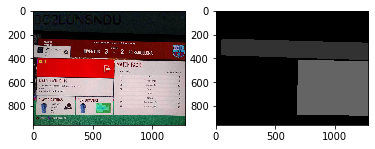

In [14]:
f_name = 'data/img00.jpg'
m_name = 'annotations_stat_segm/img00.png'
img = cv2.imread(f_name)
msk = cv2.imread(m_name)
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(msk*50)

## Create dataset

In [15]:
for f in data.fname.unique():
    img = cv2.imread('data/'+f)
    seg = cv2.imread('annotations_stat_segm/'+f.split('.')[0]+'.png')
    img_r = cv2.resize(img, (224,224))
    seg_r = cv2.resize(seg, (224,224))
    cv2.imwrite('images_train__stat_segm/'+f.split('.')[0]+'.png',img_r)
    cv2.imwrite('annotations_train__stat_segm/'+f.split('.')[0]+'.png',seg_r)

In [16]:
def augment_seg(img,seg,seq):
    aug_det = seq.to_deterministic()
    image_aug = aug_det.augment_image(img)
    segmap = ia.SegmentationMapOnImage(seg, nb_classes=np.max(seg)+1, shape=img.shape)
    segmap_aug = aug_det.augment_segmentation_maps(segmap)
    segmap_aug = segmap_aug.get_arr_int()
    return image_aug, segmap_aug

def augmentation_images(images,annotations):
    """
    images = glob.glob('images_train_2/*.png')
    annotations = glob.glob('annotations_train_2/*.png')
    """
    
    img_path = images[0].split('/')[0]
    annot_path = annotations[0].split('/')[0]
    for i,s in zip(images,annotations):
    
        fname = i.split('/')[-1].split('.')[0]
        img = cv2.imread(i)
        seg = cv2.imread(s)

        for n in range(20):

            # crop augmentation
            bnds = np.random.randint(5,40,4)
            seq_crop = iaa.Sequential([iaa.Crop(px=tuple(bnds))])
            img_aug, seg_aug = augment_seg(img,seg,seq_crop)
            cv2.imwrite( img_path + '/'+fname+'_crop'+str(n)+'.png',img_aug)
            cv2.imwrite(annot_path+'/'+fname+'_crop'+str(n)+'.png',seg_aug)

            # rotate augmentation
            seq_rotate = iaa.Sequential([iaa.Affine(rotate=(-10,10))])
            img_aug, seg_aug = augment_seg(img,seg,seq_rotate)
            cv2.imwrite(img_path+'/'+fname+'_rotate'+str(n)+'.png',img_aug)
            cv2.imwrite(annot_path+'/'+fname+'_rotate'+str(n)+'.png',seg_aug)

            # scale augmentation
            seq_scale = iaa.Sequential([iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)})])
            img_aug, seg_aug = augment_seg(img,seg,seq_scale)
            cv2.imwrite(img_path+'/'+fname+'_scale'+str(n)+'.png',img_aug)
            cv2.imwrite(annot_path+'/'+fname+'_scale'+str(n)+'.png',seg_aug)

            # blur augmentation
            seq_blur = iaa.Sequential([iaa.GaussianBlur(sigma=(0, 3.0))])
            img_aug, seg_aug = augment_seg(img,seg,seq_blur)
            cv2.imwrite(img_path+'/'+fname+'_blur'+str(n)+'.png',img_aug)
            cv2.imwrite(annot_path+'/'+fname+'_blur'+str(n)+'.png',seg_aug)

In [21]:
images = glob.glob('images_train__stat_segm/*.png')
annotations = glob.glob('annotations_train__stat_segm/*.png')
augmentation_images(images,annotations)

/home/vasylcf/anaconda3/lib/python3.7/site-packages/imgaug/imgaug.py:182: DeprecationWarning: Function `SegmentationMapOnImage()` is deprecated. Use `SegmentationMapsOnImage` instead. (Note the plural 'Maps' instead of old 'Map'.).
  warn_deprecated(msg, stacklevel=3)
/home/vasylcf/anaconda3/lib/python3.7/site-packages/imgaug/imgaug.py:107: DeprecationWarning: Providing nb_classes to SegmentationMapsOnImage is no longer necessary and hence deprecated. The argument is ignored and can be safely removed.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/home/vasylcf/anaconda3/lib/python3.7/site-packages/imgaug/imgaug.py:182: DeprecationWarning: Method `SegmentationMapsOnImage.get_arr_int()` is deprecated. Use `SegmentationMapsOnImage.get_arr()` instead.
  warn_deprecated(msg, stacklevel=3)


## Create validation dataset

In [22]:
!mv images_train__stat_segm/img04*.png validation__stat_segm/
!mv images_train__stat_segm/img09*.png validation__stat_segm/
!mv annotations_train__stat_segm/img04*.png annotation_validation__stat_segm/
!mv annotations_train__stat_segm/img09*.png annotation_validation__stat_segm/

## Model

In [23]:
from keras_segmentation.models import unet

In [24]:
model = unet.mobilenet_unet(n_classes=4, input_height=224, input_width=224,)

Instructions for updating:
Colocations handled automatically by placer.


In [25]:
model.train(
    train_images =  "images_train__stat_segm/",
    train_annotations = "annotations_train__stat_segm/",
    validate = True,
    val_images = "validation__stat_segm/",
    val_annotations = "annotation_validation__stat_segm/",
    epochs=5
)

  9%|▉         | 57/648 [00:00<00:01, 561.02it/s]

Verifying training dataset


 35%|███▍      | 56/162 [00:00<00:00, 557.57it/s]

Dataset verified! 
Verifying validation dataset


100%|██████████| 162/162 [00:00<00:00, 564.15it/s]


Dataset verified! 
Starting Epoch  0
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/1
512/512 [==============================] - 62s 121ms/step - loss: 0.1082 - accuracy: 0.9667 - val_loss: 0.0748 - val_accuracy: 0.9710
Finished Epoch 0
Starting Epoch  1
Epoch 1/1
512/512 [==============================] - 51s 99ms/step - loss: 0.0174 - accuracy: 0.9940 - val_loss: 0.0542 - val_accuracy: 0.9763
Finished Epoch 1
Starting Epoch  2
Epoch 1/1
512/512 [==============================] - 51s 100ms/step - loss: 0.0111 - accuracy: 0.9961 - val_loss: 0.0945 - val_accuracy: 0.9784
Finished Epoch 2
Starting Epoch  3
Epoch 1/1
512/512 [==============================] - 51s 100ms/step - loss: 0.0087 - accuracy: 0.9970 - val_loss: 0.0855 - val_accuracy: 0.9761
Finished Epoch 3
Starting Epoch  4
Epoch 1/1
512/512 [==============================] - 51s 100ms/step - loss: 0.0071 - accuracy: 0.9975 - val_loss: 0.0997 -

In [26]:
model.save('segm_mob_224_224__stat_segm.h5')

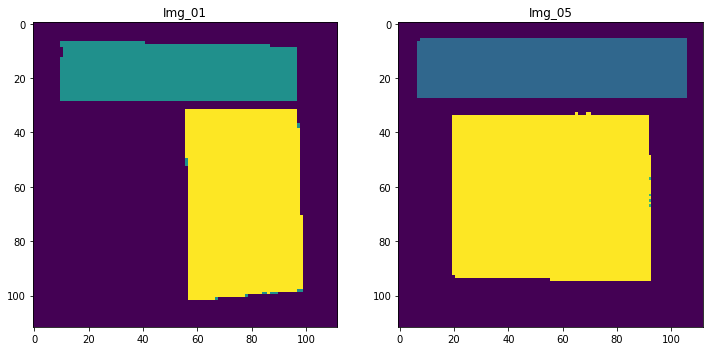

In [108]:
out_1 = model.predict_segmentation(inp="images_train__stat_segm/img01.png")
out_2 = model.predict_segmentation(inp="images_train__stat_segm/img05.png")
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title('Img_01')
plt.imshow(out_1)
plt.subplot(1,2,2)
plt.title('Img_05')
plt.imshow(out_2)

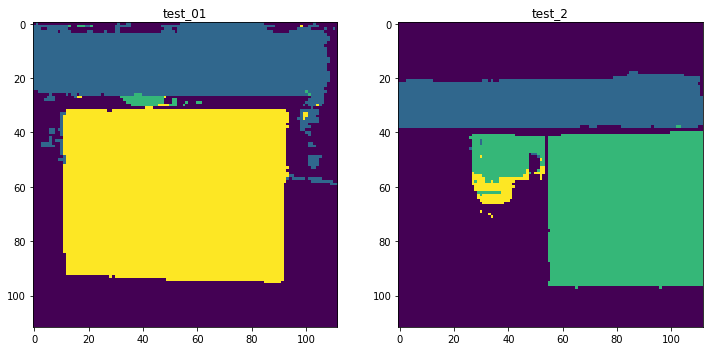

In [109]:
test_1 = model.predict_segmentation(inp="test_img/mob_test_1.png")
test_2 = model.predict_segmentation(inp="test_img/mob_test_2.png")
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title('test_01')
plt.imshow(test_1)
plt.subplot(1,2,2)
plt.title('test_2')
plt.imshow(test_2)

In [129]:
np.mean([3,4,3,3,3,2])

3.0

## Test IOU

In [174]:
def find_segments(mask_img,cls):
    segments={}
    for cl in cls:
        cols = np.sum(mask_img==cl,axis=1)
        rows = np.sum(mask_img==cl,axis=0)
        col_cond1= (cols>=np.mean(cols[cols>4])/1.5)
        #col_cond2 = (cols<np.mean(cols[cols>4])*1.5)
        row_cond1= (rows>=np.mean(rows[rows>4])/1.5)
        #row_cond2 = (rows<np.mean(rows[rows>4])*1.5)
        col_indecies = np.where(col_cond1)[0]
        row_indecies = np.where(row_cond1)[0]

        x1 = row_indecies[0]
        y1 = col_indecies[0]
        x2 = row_indecies[-1]
        y2 = col_indecies[-1]
        
        segments[cl] = [(x1,y1),(x2,y2)]
    
    return segments

def crop_rect(im, rect, scaler={'h': 1, 'w': 1}):
    crop_img = im[rect[0][1]*scaler['h']:rect[1][1]*scaler['h'], rect[0][0]*scaler['w']:rect[1][0]*scaler['w']]
    #[(x1,y1),(x2,y2)]
    coordinates = [(rect[0][0]*scaler['w'],rect[0][1]*scaler['h']),
                   (rect[1][0]*scaler['w'],rect[1][1]*scaler['h'])]
            
    return crop_img, coordinates

def detect_classes(img,n_classes):
    # result is better when we know names of classes
    labels, counts = np.unique(img,return_counts=True)
    labels = labels[1:]
    counts = counts[1:]
    inds = np.argsort(counts)
    list_classes = []
    for i in range(1,n_classes+1):
        list_classes.append(labels[inds[-i]])
    return list_classes

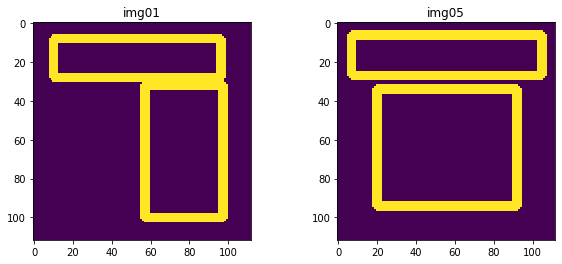

In [111]:
plt.figure(figsize=(10,4))
segments = find_segments(out_1,[1,2])
m = np.zeros(out_1.shape)
for s in segments:
    cv2.rectangle(m,*segments[s],(255,255,0),3)

plt.subplot(1,2,1)
plt.title('img01')
plt.imshow(m)

segments = find_segments(out_2,[1,3])
m = np.zeros(out_1.shape)
for s in segments:
    cv2.rectangle(m,*segments[s],(255,255,0),3)

plt.subplot(1,2,2)
plt.title('img05')
plt.imshow(m)

In [175]:
def build_hist(mask_img, labels):
    segments={}
    for cl in labels:
        cols = np.sum(mask_img==cl,axis=0)
        rows = np.sum(mask_img==cl,axis=1)
        segments[cl]={'cols':cols, 'rows':rows}
    
    r=len(labels)
    c=3
    k=1
    plt.figure(figsize=(14,8))
    for i in segments:
        plt.subplot(r,c,k)
        plt.title(f'Label:{i},rows')
        plt.axis([0,112,0,112])
        plt.grid()
        ax=plt.gca()
        ax.set_ylim(ax.get_ylim()[::-1])
        ax.set_aspect('equal')
        plt.barh(np.arange(1,113),segments[i]['rows'])
        k+=1
        plt.subplot(r,c,k)
        plt.title(f'Label:{i},cols')
        plt.bar(np.arange(1,113),segments[i]['cols'])
        plt.axis([0,112,0,112])
        plt.grid()
        ax=plt.gca()
        ax.set_aspect('equal')
        ax.set_ylim(ax.get_ylim()[::-1])
        k+=1
        plt.subplot(r,c,k)
        plt.title(f'mask')
        plt.imshow(mask_img)
        k+=1

Find segments: 2


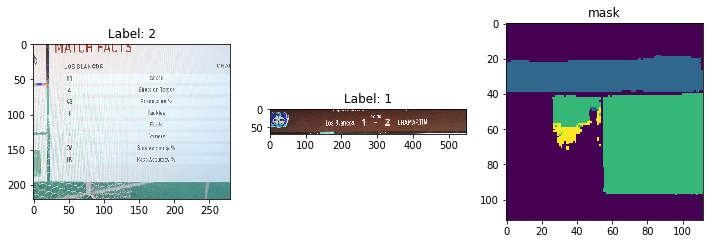

In [176]:
#test_img/mob_test_2.png"
msk = analysis(f='test_2.png', path='test_img/')

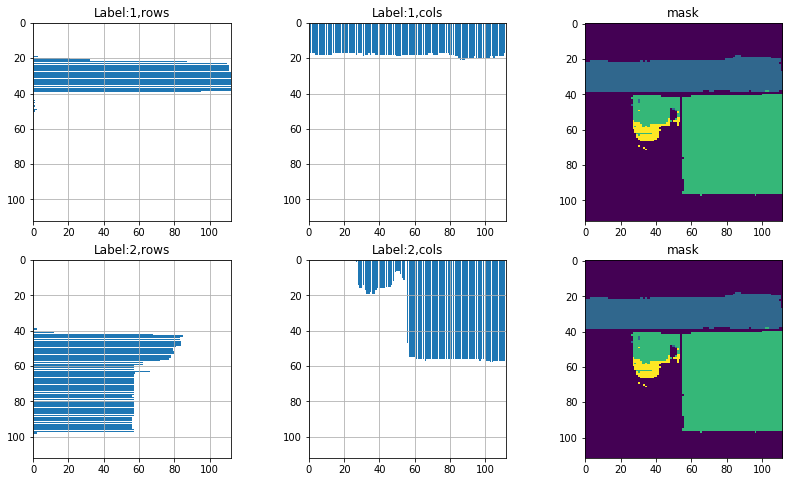

In [177]:
build_hist(test_2,[1,2])

In [114]:
test_data = pd.read_csv('test_labeled_dataset/data_test_stat_segm.csv')
test_data = test_data.rename(columns={'class':'labels'})
test_data['img_type'] = test_data['fname'].apply(lambda x: 1 if int(re.findall(r'\d+',x.split('.')[0])[0])<11 else 2)
test_data['fname'] = test_data['fname'].apply(lambda x: x[3:])
test_data.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,bbox_x3,bbox_y3,bbox_x4,bbox_y4,labels,fname,img_type
0,87,20,1190,0,1195,113,81,138,1,01.jpg,1
1,614,142,1196,125,1222,564,611,558,2,01.jpg,1
2,173,195,1900,203,1927,395,159,391,1,02.jpg,1
3,1071,419,1927,419,2011,1090,1075,1105,2,02.jpg,1
4,485,165,3769,177,3745,581,509,541,1,03.jpg,1


In [115]:
def create_annotations(FF,img_folder, annotation_folder):
    for f in FF.fname.unique():
        img = cv2.imread(img_folder+f)
        print(img_folder+f)
        mask = np.zeros(img.shape)
        T = FF[FF.fname==f]
        for cl in T['labels']:
            pts = T[T['labels']==cl][['bbox_x1','bbox_y1','bbox_x2','bbox_y2','bbox_x3','bbox_y3','bbox_x4','bbox_y4']].values[0].reshape(4,2)
            pts = pts.astype('int')
            mask = cv2.fillPoly(mask,[pts],color=(cl,cl,cl))
        cv2.imwrite(annotation_folder+f.split('.')[0]+'.png',mask)

In [61]:
#let's create annotations
img_folder = 'test_labeled_dataset/data/'
annotation_folder = 'test_labeled_dataset/annotations_test_stat_segm/'
create_annotations(test_data,img_folder, annotation_folder)

test_labeled_dataset/data/01.jpg
test_labeled_dataset/data/02.jpg
test_labeled_dataset/data/03.jpg
test_labeled_dataset/data/04.jpg
test_labeled_dataset/data/05.jpg
test_labeled_dataset/data/06.jpg
test_labeled_dataset/data/07.jpg
test_labeled_dataset/data/08.jpg
test_labeled_dataset/data/09.jpg
test_labeled_dataset/data/10.jpg
test_labeled_dataset/data/11.jpg
test_labeled_dataset/data/12.jpg
test_labeled_dataset/data/13.jpg
test_labeled_dataset/data/14.jpg
test_labeled_dataset/data/15.jpg
test_labeled_dataset/data/16.jpg
test_labeled_dataset/data/17.jpg
test_labeled_dataset/data/18.jpg
test_labeled_dataset/data/19.jpg
test_labeled_dataset/data/20.jpg


In [116]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
 
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
 
    # return the intersection over union value
    return iou

In [178]:
m=np.array([[True,True],[False,False],[True,True],[False,False]])
n_classes = 2

predicted_boxes = {}
real_boxes = {}

IOUs = {}

for f in test_data.fname.unique():
    
    img = cv2.imread(img_folder+f)
    img_r = cv2.resize(img, (224,224))
    
    out = model.predict_segmentation(img_r)
    h_scale = int(np.round(img.shape[0] / out.shape[0], 0))
    w_scale = int(np.round(img.shape[1] / out.shape[1], 0))
    scaler = {'h': h_scale, 'w': w_scale, }
    list_cls = detect_classes(out,n_classes)
    rects = find_segments(out,list_cls)
    segments = {}
    for r in rects:
        crop_img, coordinates = crop_rect(img, rects[r], scaler=scaler)
        segments[r]={'data': crop_img, 'coordinates':coordinates}
    
    predicted_boxes[f] = segments
    
    real_boxes[f]={}
    IOUs[f] = {}
    
    for l in test_data[test_data.fname==f].labels:
        pts=test_data[(test_data.fname==f)&(test_data.labels==l)].iloc[:,:-3].values[0].astype('int').reshape(4,2)
        real_boxes[f][l] = pts[m]
        
        boxA= np.ravel(segments[l]['coordinates'])
        boxB = pts[m]
    
        IOUs[f][l] = bb_intersection_over_union(boxA, boxB)

In [179]:
IOUs

{'01.jpg': {1: 0.67305559738784, 2: 0.7714203910811995},
 '02.jpg': {1: 0.9398431474110315, 2: 0.9136224760892667},
 '03.jpg': {1: 0.8603979741689629, 2: 0.9279044567756667},
 '04.jpg': {1: 0.905405883591443, 2: 0.9259117238413368},
 '05.jpg': {1: 0.8529972606868829, 2: 0.9481666070449555},
 '06.jpg': {1: 0.8841021658029768, 2: 0.8316608532331634},
 '07.jpg': {1: 0.6043495963006292, 2: 0.9031346411789024},
 '08.jpg': {1: 0.853271651045306, 2: 0.9190179208285542},
 '09.jpg': {1: 0.4433644571644717, 2: 0.9271348428018377},
 '10.jpg': {1: 0.7863960347854027, 2: 0.9493556663520195},
 '11.jpg': {1: 0.9247011509051084, 3: 0.941528657700715},
 '12.jpg': {1: 0.7410323709536308, 3: 0.8389877305906918},
 '13.jpg': {1: 0.7792466672716198, 3: 0.9257819187263611},
 '14.jpg': {1: 0.9081967127344263, 3: 0.9514743333995961},
 '15.jpg': {1: 0.6535957015265275, 3: 0.8717152621288298},
 '16.jpg': {1: 0.915505290428288, 3: 0.9313957281928797},
 '17.jpg': {1: 0.7358153975688049, 3: 0.8479803268284943},
 '1

In [180]:
ACC = pd.DataFrame.from_dict(IOUs, orient='index')
ACC.mean()

1    0.802202
2    0.901733
3    0.915733
dtype: float64

## low accuracy

In [181]:
def analysis(f,path='test_labeled_dataset/data/', size=(224,224), n_classes=2, model=model):
    img = cv2.imread(path+f)
    img_r = cv2.resize(img, size)

    out = model.predict_segmentation(img_r)

    h_scale = int(np.round(img.shape[0] / out.shape[0], 0))
    w_scale = int(np.round(img.shape[1] / out.shape[1], 0))
    scaler = {'h': h_scale, 'w': w_scale, }

    list_cls = detect_classes(out,n_classes)
    rects = find_segments(out,list_cls)
    segments = []
    for r in rects:
        crop_img, coordinates = crop_rect(img, rects[r], scaler=scaler)
        segments.append({'label': r, 'data': crop_img, 'coordinates':coordinates})

    print(f'Find segments: {len(segments)}')
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title(f"Label: {segments[0]['label']}")
    plt.imshow(segments[0]['data'])
    plt.subplot(1,3,2)
    plt.title(f"Label: {segments[1]['label']}")
    plt.imshow(segments[1]['data'])
    plt.subplot(1,3,3)
    plt.title(f"mask")
    plt.imshow(out)
    return out
    

Find segments: 2


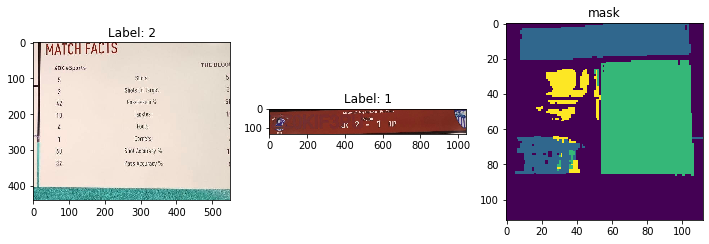

In [182]:
msk = analysis(f='01.jpg')

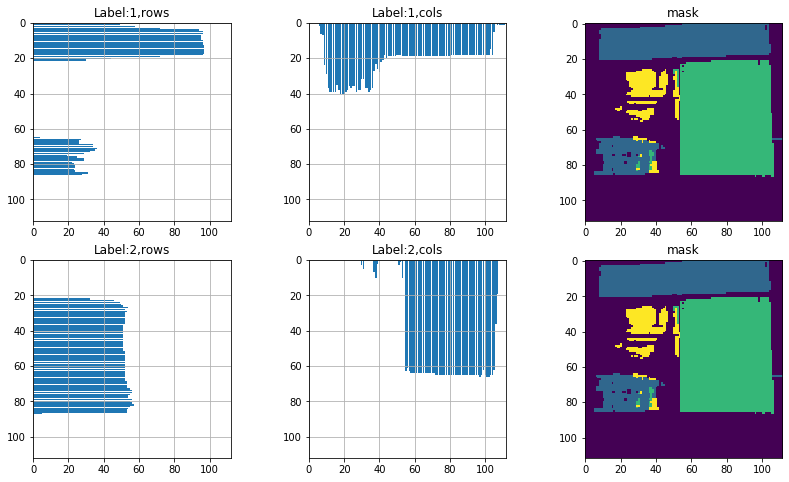

In [183]:
build_hist(msk,[1,2])

Find segments: 2


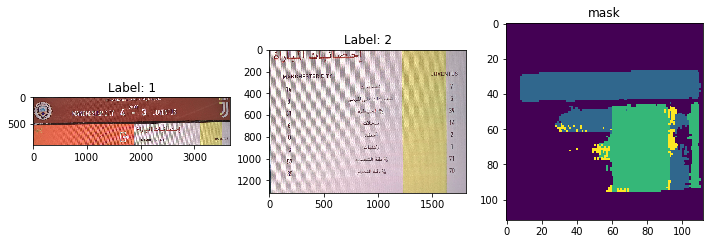

In [186]:
msk_9 = analysis(f='09.jpg')

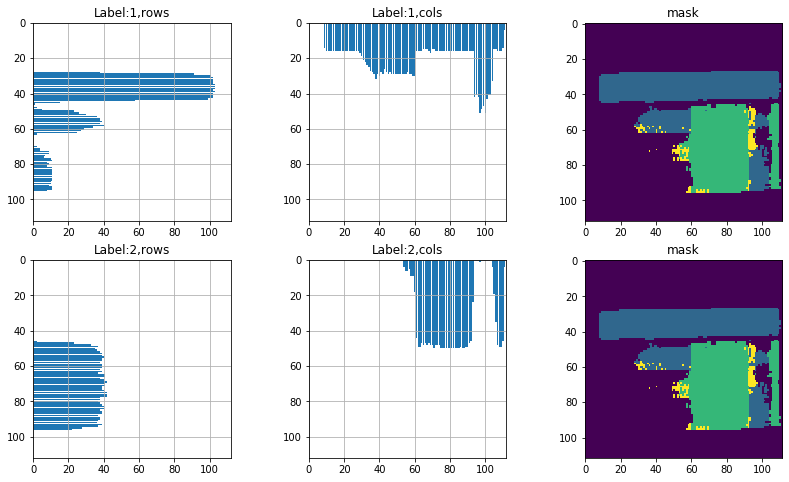

In [187]:
build_hist(msk_9,[1,2])

In [ ]:
low_acc_samples = ['01.jpg', '09.jpg']
